# Predittore - fast implementation

Asvestis' solution for #EUvsVirus Hackathon 

## Introduction

Research notebook for prediction models.

We need dataclasses, pandas

In [222]:
from dataclasses import dataclass
import pandas as pd
import json

@dataclass
class Values:
    def __init__(self, value: pd.DataFrame):
        self.value = value
        self.value_ma = self.value.rolling(window=7).mean()

    def get(self):
        return {
            'Raw': self.value.fillna(0).to_dict(),
            'Moving Average 7 days': self.value_ma.fillna(0).to_dict()
        }

@dataclass
class Measurement:
    def __init__(self, measurement: pd.DataFrame):
        self.measurement = Values(measurement)
        self.measurement_diff = Values(measurement.diff())

    def get(self):
        return {
            'Cumulative': self.measurement.get(),
            'Daily new': self.measurement_diff.get()
        }

@dataclass
class COVID19:
    def __init__(self, confirmed: pd.DataFrame, deaths: pd.DataFrame, recovered: pd.DataFrame):
        self.confirmed = Measurement(confirmed)
        self.deaths = Measurement(deaths)
        self.recovered = Measurement(recovered)

    def to_json(self):
        return json.dmps({
            'confirmed': self.confirmed.get(),
            'deaths': self.deaths.get(),
            'recovered': self.recovered.get()
        })

Load up the data from the COVID-19 submodule

In [223]:
import os

# Get the base folder relatively to COVID-19
base_folder = os.path.join('..', 'COVID-19', 'csse_covid_19_data', 'csse_covid_19_time_series')

confirmed = pd.read_csv(os.path.join(base_folder, 'time_series_covid19_confirmed_global.csv'), sep=',')
deaths = pd.read_csv(os.path.join(base_folder, 'time_series_covid19_deaths_global.csv'), sep=',')
recovered = pd.read_csv(os.path.join(base_folder, 'time_series_covid19_recovered_global.csv'), sep=',')
confirmed

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20
0,NaN,Afghanistan,33.000000,65.000000,0,0,0,0,0,0,...,714,784,840,906,933,996,1026,1092,1176,1279
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,...,475,494,518,539,548,562,584,609,634,663
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,...,2070,2160,2268,2418,2534,2629,2718,2811,2910,3007
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,...,659,673,673,696,704,713,717,717,723,723
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,...,19,19,19,19,24,24,24,24,25,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,Saint Pierre and Miquelon,France,46.885200,-56.315900,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
260,NaN,South Sudan,6.877000,31.307000,0,0,0,0,0,0,...,4,4,4,4,4,4,4,4,4,5
261,NaN,Western Sahara,24.215500,-12.885800,0,0,0,0,0,0,...,6,6,6,6,6,6,6,6,6,6
262,NaN,Sao Tome and Principe,0.186360,6.613081,0,0,0,0,0,0,...,4,4,4,4,4,4,4,4,4,4


We wrote a little function to extract data 

In [224]:
import calendar
import datetime

def makeComputations(countries):
    global base_folder

    confirmed = pd.read_csv(os.path.join(base_folder, 'time_series_covid19_confirmed_global.csv'), sep=',')
    deaths = pd.read_csv(os.path.join(base_folder, 'time_series_covid19_deaths_global.csv'), sep=',')
    recovered = pd.read_csv(os.path.join(base_folder, 'time_series_covid19_recovered_global.csv'), sep=',')

    get_total_per_country = lambda df: df.sum(axis=0) if not df.isnull().values.any() else df[df.isna().any(axis=1)]
    # clean_date = lambda df: df.set_index(pd.Index([datetime.date(2000 + int(dd.split('/')[2]), int(dd.split('/')[0]), int(dd.split('/')[1])) for dd in list(df.index.values)]))
    clean_date = lambda df: df.set_index(pd.Index([calendar.timegm(datetime.date(2000 + int(dd.split('/')[2]), int(dd.split('/')[0]), int(dd.split('/')[1])).timetuple()) for dd in list(df.index.values)]))

    # countries = [k for k, _ in countries.items()]

    objs = []
    for obj in [confirmed, deaths, recovered]:
        dfs = []
        for c in countries:
            total = get_total_per_country(obj[obj['Country/Region'] == c])
            if isinstance(total, pd.core.frame.Series):
                total = pd.DataFrame(total)
                total = total.transpose()
            total = total.drop(['Province/State', 'Country/Region', 'Lat', 'Long'], axis=1)
            total = total.set_index(pd.Index(['Total ' + c]))
            total = total.transpose()
            total = clean_date(total)
            dfs.append(total)
        objs.append(pd.concat(dfs, axis=1, sort=False))

    selected = COVID19(objs[0], objs[1], objs[2])

    return selected

all_countries = makeComputations(confirmed['Country/Region'].drop_duplicates())

## Logistic regression

We use the following relationship

$$
y(x) = \frac{A}{1 - e^{-k \cdot (x - x_0)}} + B
$$

- $[A, k, x_0, B] \in \mathbb{R}$

In [225]:
import numpy as np
from scipy.optimize import curve_fit

In [226]:
def logisticRegression(x, y, forward=7 * 48):
    sigmoid = lambda x, A, B, k, x0: A / (1 + np.exp(-k*(x-x0)))+B

    popt, _ = curve_fit(sigmoid, x, y)

    return sigmoid(range(len(x) + forward), *popt)

## Gaussian regression

We use the following function:

$$
y(x) = A \times e^{\frac{-(x - x_0)^2}{2 \cdot \sigma^2}}
$$

- $[A, x_0, \sigma] \in \mathbb{R}$

In [227]:
def gaussRegression(x ,y, forward=7 * 48):
    gauss = lambda x, a, x0, sigma: a*np.exp(-(x-x0)**2/(2*sigma**2))

    popt, _ = curve_fit(gauss, x, y)

    return gauss(range(len(x) + forward), *popt)

## Use case

For accessing data we must use either the *all_countries* variable

The data tree is the following:

```
all_countries
|
--- confirmed
|   |
|    --- measurement (raw CUMULATIVE data from John Hopkins)
|        |
|        --- value (the measurement raw value)
|        --- value_ma (moving average measurement)
|
|    --- measurement_diff (derivate of raw cumulative data from John Hopkins)
|        |
|        --- value (the measurement_diff computed value)
|        --- value_ma (moving average of measurement derivate computed value)
--- deaths
|
|
|
--- recovered
```

Same logic applies to deaths and recovered

In [228]:
countries = ['Italy']

for country in countries:
    confirmed_cumulative_raw = all_countries.confirmed.measurement.value[f'Total {country}']
    confirmed_cumulative_moving_average = all_countries.confirmed.measurement.value_ma[f'Total {country}']
    
    confirmed_derivate_raw = all_countries.confirmed.measurement_diff.value[f'Total {country}']
    confirmed_derivate_moving_average = all_countries.confirmed.measurement_diff.value_ma[f'Total {country}']

print(confirmed_cumulative_raw)

1579651200         0
1579737600         0
1579824000         0
1579910400         0
1579996800         0
               ...  
1587254400    178972
1587340800    181228
1587427200    183957
1587513600    187327
1587600000    189973
Name: Total Italy, Length: 93, dtype: int64


In [229]:
print(confirmed_cumulative_moving_average)

1579651200              NaN
1579737600              NaN
1579824000              NaN
1579910400              NaN
1579996800              NaN
                  ...      
1587254400    169061.571429
1587340800    172163.285714
1587427200    175230.285714
1587513600    178397.714286
1587600000    181402.285714
Name: Total Italy, Length: 93, dtype: float64


<module 'matplotlib.pyplot' from '/home/redeye/miniconda3/envs/bio/lib/python3.8/site-packages/matplotlib/pyplot.py'>

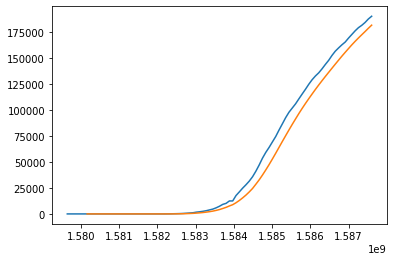

In [230]:
import matplotlib.pyplot as plt

plt.plot(confirmed_cumulative_raw)
plt.plot(confirmed_cumulative_moving_average)
plt

<module 'matplotlib.pyplot' from '/home/redeye/miniconda3/envs/bio/lib/python3.8/site-packages/matplotlib/pyplot.py'>

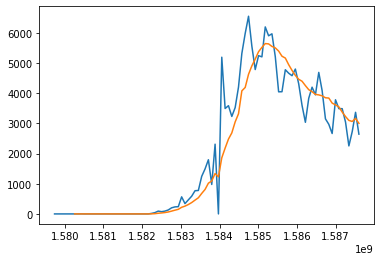

In [231]:
plt.plot(confirmed_derivate_raw)
plt.plot(confirmed_derivate_moving_average)
plt

### Derivate regression

Looks like a gaussian function:

[32.68085106 33.70212766 34.72340426 35.74468085 36.76595745 37.78723404
 38.80851064 39.82978723 40.85106383 41.87234043 42.89361702 43.91489362
 44.93617021 45.95744681 46.9787234  48.         49.0212766  50.04255319
 51.06382979 52.08510638 53.10638298 54.12765957 55.14893617 56.17021277
 57.19148936 58.21276596 59.23404255 60.25531915 61.27659574 62.29787234
 63.31914894 64.34042553 65.36170213 66.38297872 67.40425532 68.42553191
 69.44680851 70.46808511 71.4893617  72.5106383  73.53191489 74.55319149
 75.57446809 76.59574468 77.61702128 78.63829787 79.65957447 80.68085106
 81.70212766 82.72340426 83.74468085 84.76595745 85.78723404 86.80851064
 87.82978723 88.85106383 89.87234043 90.89361702 91.91489362 92.93617021
 93.95744681] [  21.71428571   32.28571429   45.57142857   64.28571429   93.14285714
  124.          152.28571429  219.85714286  258.14285714  311.42857143
  376.57142857  457.57142857  535.42857143  679.28571429  811.57142857
 1019.42857143 1092.42857143 1339.         

/home/redeye/miniconda3/envs/bio/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


<module 'matplotlib.pyplot' from '/home/redeye/miniconda3/envs/bio/lib/python3.8/site-packages/matplotlib/pyplot.py'>

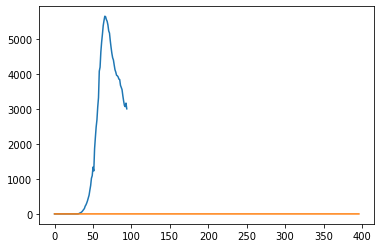

In [246]:
df = confirmed_derivate_moving_average.fillna(0)
x = df.index.values
y = df.values

x = (x - x.min()) / 84600
xs = np.where(y > 10)[0][0]
xdata = x[xs:]
ydata = y[xs:]

print(xdata, ydata)

res = gaussRegression(xdata, ydata)

plt.plot(x, y)
plt.plot(res)
plt

### Cumulative regression

This looks like a sigmoid proble

[ 5.10638298  6.12765957  7.14893617  8.17021277  9.19148936 10.21276596
 11.23404255 12.25531915 13.27659574 14.29787234 15.31914894 16.34042553
 17.36170213 18.38297872 19.40425532 20.42553191 21.44680851 22.46808511
 23.4893617  24.5106383  25.53191489 26.55319149 27.57446809 28.59574468
 29.61702128 30.63829787 31.65957447 32.68085106 33.70212766 34.72340426
 35.74468085 36.76595745 37.78723404 38.80851064 39.82978723 40.85106383
 41.87234043 42.89361702 43.91489362 44.93617021 45.95744681 46.9787234
 48.         49.0212766  50.04255319 51.06382979 52.08510638 53.10638298
 54.12765957 55.14893617 56.17021277 57.19148936 58.21276596 59.23404255
 60.25531915 61.27659574 62.29787234 63.31914894 64.34042553 65.36170213
 66.38297872 67.40425532 68.42553191 69.44680851 70.46808511 71.4893617
 72.5106383  73.53191489 74.55319149 75.57446809 76.59574468 77.61702128
 78.63829787 79.65957447 80.68085106 81.70212766 82.72340426 83.74468085
 84.76595745 85.78723404 86.80851064 87.82978723 88.8

<module 'matplotlib.pyplot' from '/home/redeye/miniconda3/envs/bio/lib/python3.8/site-packages/matplotlib/pyplot.py'>

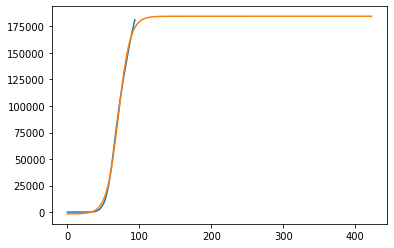

In [245]:
df = confirmed_cumulative_moving_average.fillna(0)
x = df.index.values
y = df.values

x = (x - x.min()) / 84600
xs = np.where(x > 5)[0][0]
xdata = x[xs:]
ydata = y[xs:]

print(xdata, ydata)

res = logisticRegression(xdata, ydata)

plt.plot(x, y)
plt.plot(res)
plt